# Train script for Advanced Hybrid VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train
from helpers import kl_loss,nll_loss,mse_loss,kl_loss_multi
from models import AdvancedHybridVAE
from ToyDatasets.timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 32
num_steps = 16
dataset_size = 5000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)

## Define model

In [3]:
model = AdvancedHybridVAE(input_size=1,conv_size=256,rnn_size=256,latent_size=64,output_size=num_classes,use_softmax=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()
    x = Variable(initial_batch).type(torch.FloatTensor).transpose(1,0)
    test,_,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 1054868
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=5)

## Run trainer


Train (1 2%) elbo: -1.9719 r_loss: -1.6268 kl: 7216.6959 aux_loss: -1.1504 beta 0.00e+00
Valid (1 2%) elbo: -0.9834 r_loss: -0.8575 kl: 24440.7910 aux_loss: -0.4198 beta 0.00e+00

Train (2 4%) elbo: -1.1920 r_loss: -0.7410 kl: 1490.8751 aux_loss: -0.4893 beta 2.04e-04
Valid (2 4%) elbo: -0.7517 r_loss: -0.5153 kl: 585.0525 aux_loss: -0.3899 beta 2.04e-04

Train (3 6%) elbo: -0.7426 r_loss: -0.4643 kl: 404.4358 aux_loss: -0.3773 beta 4.08e-04
Valid (3 6%) elbo: -0.6883 r_loss: -0.4197 kl: 390.1301 aux_loss: -0.3647 beta 4.08e-04

Train (4 8%) elbo: -0.6957 r_loss: -0.3984 kl: 307.4980 aux_loss: -0.3634 beta 6.12e-04
Valid (4 8%) elbo: -0.6853 r_loss: -0.3848 kl: 316.7516 aux_loss: -0.3550 beta 6.12e-04

Train (5 10%) elbo: -0.6967 r_loss: -0.3776 kl: 258.4395 aux_loss: -0.3602 beta 8.16e-04
Valid (5 10%) elbo: -0.7131 r_loss: -0.3927 kl: 257.0711 aux_loss: -0.3685 beta 8.16e-04

Train (6 12%) elbo: -0.7001 r_loss: -0.3633 kl: 226.1144 aux_loss: -0.3536 beta 1.02e-03
Valid (6 12%) elbo:


Train (47 94%) elbo: -1.0915 r_loss: -0.4741 kl: 49.0784 aux_loss: -0.5223 beta 9.39e-03
Epoch    46: reducing learning rate of group 0 to 1.2500e-05.
Valid (47 94%) elbo: -1.1365 r_loss: -0.5017 kl: 50.0021 aux_loss: -0.5513 beta 9.39e-03

Train (48 96%) elbo: -1.0943 r_loss: -0.4713 kl: 48.6380 aux_loss: -0.5217 beta 9.59e-03
Valid (48 96%) elbo: -1.1935 r_loss: -0.5265 kl: 51.1814 aux_loss: -0.5867 beta 9.59e-03

Train (49 98%) elbo: -1.0972 r_loss: -0.4714 kl: 47.8514 aux_loss: -0.5235 beta 9.80e-03
Valid (49 98%) elbo: -1.0992 r_loss: -0.4680 kl: 48.3513 aux_loss: -0.5252 beta 9.80e-03

Train (50 100%) elbo: -1.1102 r_loss: -0.4794 kl: 47.1262 aux_loss: -0.5319 beta 1.00e-02
Valid (50 100%) elbo: -1.0701 r_loss: -0.4559 kl: 46.6658 aux_loss: -0.4918 beta 1.00e-02


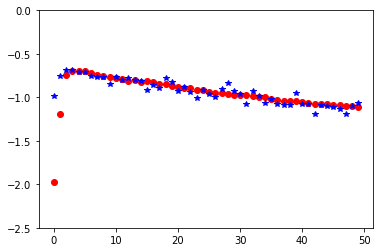

In [6]:
# use at least 50 iterations to get good results
train(data_loader,valid_data_loader,model,optimizer,scheduler,loss_fn=nll_loss,kl_loss_fn=kl_loss_multi,n_iters=50,use_softmax=True,max_beta=1e-2,print_every=1,plot_pred=False)

In [ ]:
#torch.save(model.state_dict(),"Saved_models/HybridVAE_nll_map.pt")